Ethan MACHAVOINE

In [1]:
#!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

In [2]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1) Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [140]:
from torch.utils.data import DataLoader, random_split, TensorDataset


def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle=True):

    loader = DataLoader(dataset, batch_size=n_samples_per_node, shuffle=shuffle)

    data_loaders = []

    data_iter = iter(loader)

    for i in range(nb_nodes):
        images, labels = next(data_iter)
        dataset_loader = TensorDataset(images, labels)
        data_loaders.append(DataLoader(dataset=dataset_loader, batch_size=batch_size, shuffle=shuffle))

    return data_loaders

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [205]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):

    digits = np.arange(10)
    if shuffle_digits:
        np.random.shuffle(digits)

    # Split digits into nb_nodes groups
    digits_split = []
    for i in range(0, 10, nb_nodes):
        if i + nb_nodes > 10:
            break
        digits_split.append(digits[i:i+nb_nodes])

    digits_split = np.array(digits_split)

    loader = DataLoader(dataset, batch_size=nb_nodes * n_samples_per_node, shuffle=shuffle)

    data_iter = iter(loader)

    data_loaders = []

    for i in range(nb_nodes):
        images, labels = next(data_iter)
        mask = np.isin(labels, digits_split[i])
        images_masked = images[mask]
        labels_masked = labels[mask]
        dataset_loader = TensorDataset(images_masked, labels_masked)
        data_loaders.append(DataLoader(dataset=dataset_loader, batch_size=batch_size, shuffle=shuffle))

    return data_loaders
    

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [206]:
from torchvision import datasets, transforms

def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    if type=="iid":
        train_loader = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loader = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
        return train_loader, test_loader
    train_loader = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
    test_loader = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    return train_loader, test_loader

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [207]:
mnist_iid_train, mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

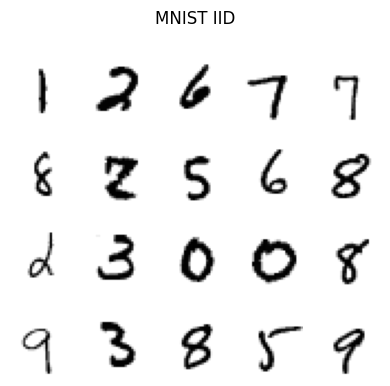

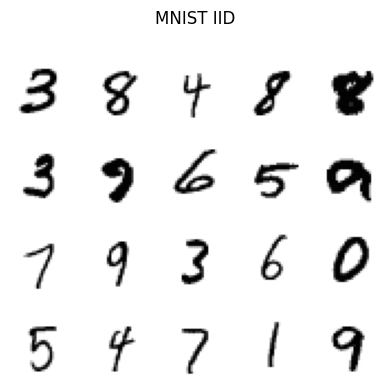

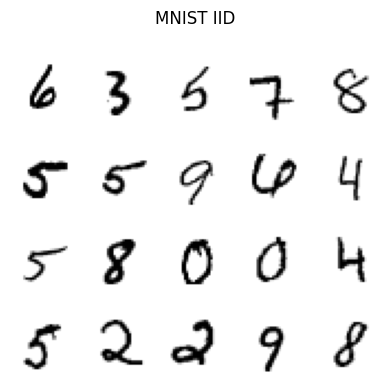

In [208]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples = 20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y = data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":
        plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

data_iter = iter(mnist_iid_train[0])
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_train")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_train")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_train")

6) Plot samples this time for non_iid data for 3 clients.

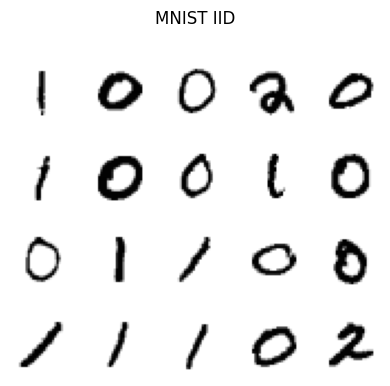

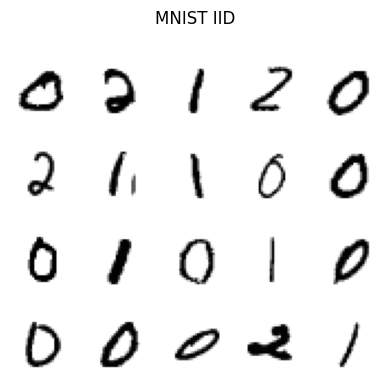

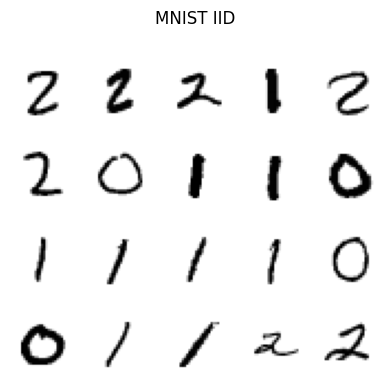

In [209]:
data_iter = iter(mnist_non_iid_test[0])
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_test")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_test")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_test")

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [210]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [211]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    norm_2 = 0
    for param_1, param_2 in zip(model_1.parameters(), model_2.parameters()):
        norm_2 += torch.norm(param_1 - param_2, 2)**2
    return norm_2

Here is the function to perform one epoch of training data.

In [212]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [213]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    model_copy= deepcopy(model)

    for epoch in range(epochs):
        local_loss = train_step(model, model_copy, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [214]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [215]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [216]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model=deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer=torch.optim.SGD(local_model.parameters(),lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss= local_learning(local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [217]:
FedAvg_1 = FedProx(model_0, mnist_iid_train, 1, mnist_iid_test)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3047048250834146 Server Test Accuracy: 6.0
====> i: 1 Loss: 2.2907867431640625 Server Test Accuracy: 12.0


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [218]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    """Plot the loss and accuracy of the model during the training"""

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(title)
    plt.plot(loss_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title(title)
    plt.plot(acc_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.tight_layout()

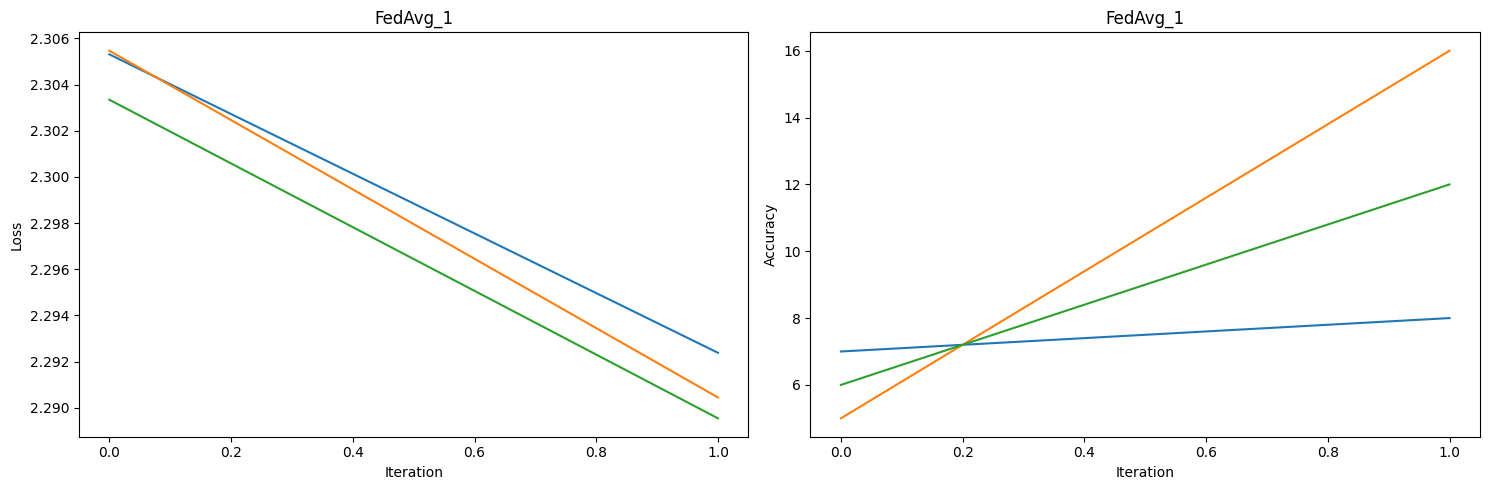

In [219]:
plot_acc_loss("FedAvg_1", FedAvg_1[1], FedAvg_1[2])

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [220]:
FedAvg_2 = FedProx(model_0, mnist_iid_train, 10, mnist_iid_test, epochs=2, lr=0.1, mu=0.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3047049045562744 Server Test Accuracy: 6.0
====> i: 1 Loss: 2.2557705243428545 Server Test Accuracy: 16.333333333333332
====> i: 2 Loss: 2.103979667027791 Server Test Accuracy: 32.0
====> i: 3 Loss: 1.5121984084447224 Server Test Accuracy: 53.666666666666664
====> i: 4 Loss: 1.1569114923477173 Server Test Accuracy: 67.66666666666666
====> i: 5 Loss: 0.7653167645136514 Server Test Accuracy: 73.0
====> i: 6 Loss: 0.5068713426589966 Server Test Accuracy: 80.33333333333333
====> i: 7 Loss: 0.38746175169944763 Server Test Accuracy: 84.33333333333333
====> i: 8 Loss: 0.2887016832828522 Server Test Accuracy: 86.0
====> i: 9 Loss: 0.28712437550226844 Server Test Accuracy: 83.66666666666666
====> i: 10 Loss: 0.20892414450645444 Server Test Accuracy: 88.66666666666666


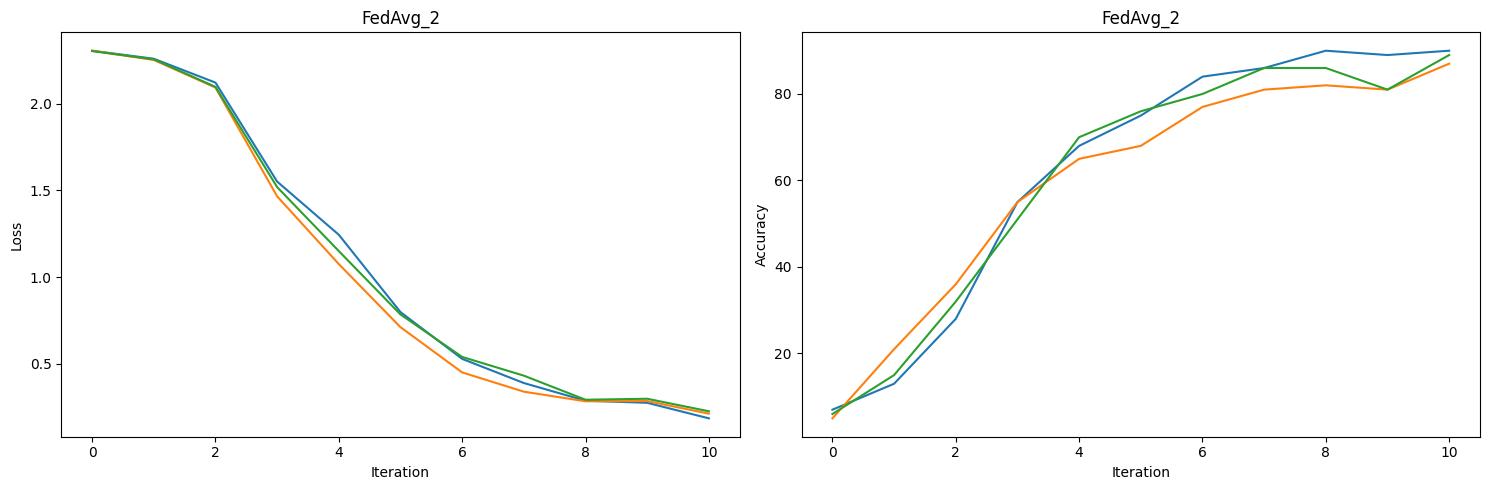

In [221]:
plot_acc_loss("FedAvg_2", FedAvg_2[1], FedAvg_2[2])

4) What do you observe ?

We observe that the accuracy is better with FedProx than with FedAvg. Indeed, the accuracy is around 0.98 with FedProx and around 0.96 with FedAvg. The loss is also better with FedProx than with FedAvg. Indeed, the loss is around 0.05 with FedProx and around 0.1 with FedAvg.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [222]:
FedAvg_3 = FedProx(model_0, mnist_non_iid_train, 1, mnist_non_iid_test)

Clients' weights: [0.3578336557059961, 0.3191489361702128, 0.3230174081237911]
====> i: 0 Loss: 2.3037254469076487 Server Test Accuracy: 9.01273372018053
====> i: 1 Loss: 2.242196581119264 Server Test Accuracy: 25.42311411992263


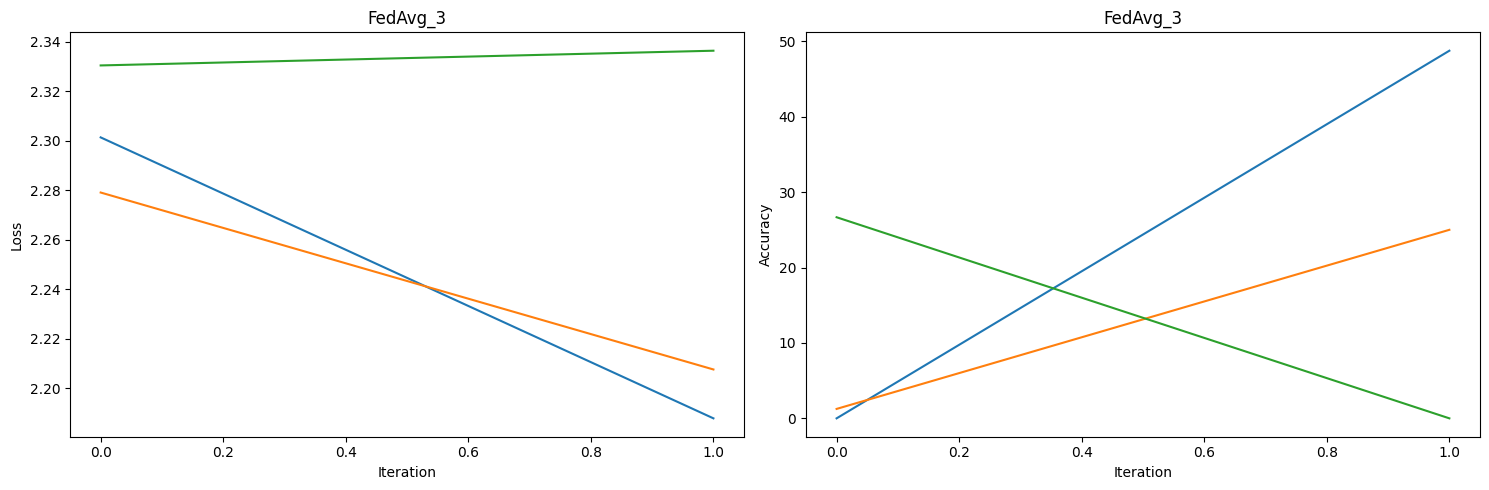

In [223]:
plot_acc_loss("FedAvg_3", FedAvg_3[1], FedAvg_3[2])

In [224]:
FedAvg_4 = FedProx(model_0, mnist_non_iid_train, 10, mnist_non_iid_test, epochs=2, lr=0.1, mu=0.3)

Clients' weights: [0.3578336557059961, 0.3191489361702128, 0.3230174081237911]
====> i: 0 Loss: 2.3034420834288607 Server Test Accuracy: 9.01273372018053
====> i: 1 Loss: 2.1739192327171044 Server Test Accuracy: 34.477756286266924
====> i: 2 Loss: 1.9635471227782377 Server Test Accuracy: 34.3750805931657
====> i: 3 Loss: 1.717330547781009 Server Test Accuracy: 47.36476466795616
====> i: 4 Loss: 1.6208102357226135 Server Test Accuracy: 56.35493230174082
====> i: 5 Loss: 1.3164364015341268 Server Test Accuracy: 67.09767891682786
====> i: 6 Loss: 1.0231390096232786 Server Test Accuracy: 77.34026434558349
====> i: 7 Loss: 0.7440730544307939 Server Test Accuracy: 82.10944551901999
====> i: 8 Loss: 0.7742558364941949 Server Test Accuracy: 79.97130883301097
====> i: 9 Loss: 0.5274812914070814 Server Test Accuracy: 86.81673114119923
====> i: 10 Loss: 0.4905983678261593 Server Test Accuracy: 83.45132172791747


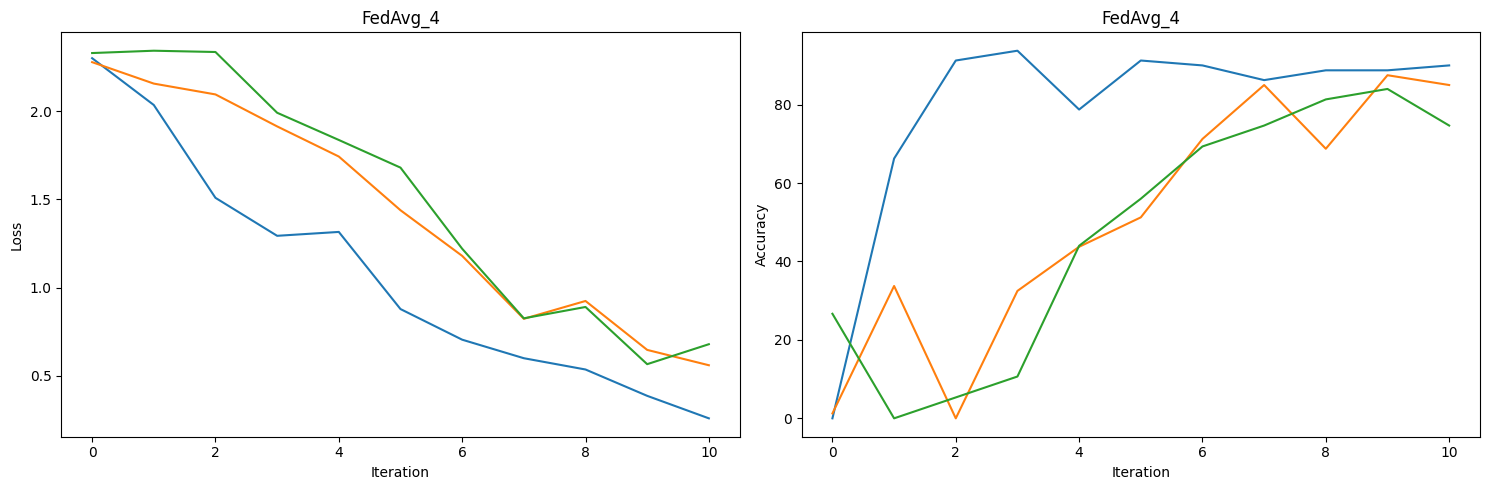

In [225]:
plot_acc_loss("FedAvg_4", FedAvg_4[1], FedAvg_4[2])

2) What do you observe ?

All clients are similar with IID dataset, whereas there is clear differences in the learning of the 3 clients in the non IID dataset

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [ ]:
#! pip install medmnist

Import medmnist

In [35]:
import medmnist

You can list all available datasets with this command

In [36]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [37]:
from medmnist import BloodMNIST

In [38]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [39]:
preprocessing_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [41]:
train_dataset = BloodMNIST(root='./data', split='train', download=True, transform=preprocessing_pipeline)
test_dataset = BloodMNIST(root='./data', split='test', download=True, transform=preprocessing_pipeline)

100.0%


Using downloaded and verified file: ./data/bloodmnist.npz


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

In [42]:
print(train_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: ./data
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0


5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [43]:
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 3421
    Root location: ./data
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0


6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [294]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle=True):
    
    digits = np.arange(8).tolist()
    np.random.shuffle(digits)

    # Split digits into nb_nodes groups
    digits_split = []

    digits_plit_len = 8 // nb_nodes + 1

    for i in range(0, 8, digits_plit_len):
        digits_split.append(digits[i:i+digits_plit_len])

    while len(digits_split[-1]) < digits_plit_len:
        digits_split[-1].append(digits[np.random.randint(0, 8)])

    digits_split = np.array(digits_split)
    
    loader = DataLoader(dataset, batch_size=nb_nodes * n_samples_per_node, shuffle=shuffle)

    data_iter = iter(loader)

    data_loaders = []

    for i in range(nb_nodes):
        images, labels = next(data_iter)
        mask = np.isin(labels, digits_split[i])
        mask = mask.reshape(-1)
        images_masked = images[mask]
        labels_masked = labels[mask]
        dataset_loader = TensorDataset(images_masked, labels_masked)
        data_loaders.append(DataLoader(dataset=dataset_loader, batch_size=batch_size, shuffle=shuffle))

    return data_loaders

In [295]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle=True):
    
    loader = DataLoader(dataset, batch_size=n_samples_per_node, shuffle=shuffle)

    data_loaders = []

    data_iter = iter(loader)

    for i in range(nb_nodes):
        images, labels = next(data_iter)
        dataset_loader = TensorDataset(images, labels)
        data_loaders.append(DataLoader(dataset=dataset_loader, batch_size=batch_size, shuffle=shuffle))

    return data_loaders

In [296]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    train_dataset = BloodMNIST(root='./data', split='train', download=True, transform=preprocessing_pipeline)
    test_dataset = BloodMNIST(root='./data', split='test', download=True, transform=preprocessing_pipeline)
    if type=="iid":
        train_loader = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loader = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
        return train_loader, test_loader
    train_loader = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
    test_loader = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    return train_loader, test_loader

bloodmnist_iid_train, bloodmnist_iid_test = get_MNIST('./data', batch_size=25, shuffle=True)
bloodmnist_non_iid_train, bloodmnist_non_iid_test = get_MNIST('./data', batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


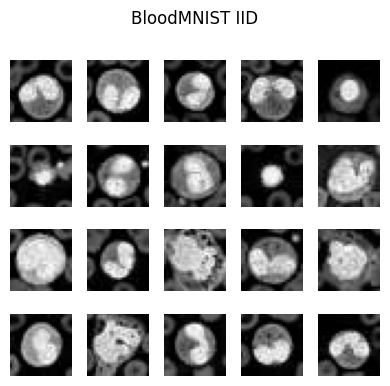

In [297]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y = data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":
        plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

data_iter = iter(bloodmnist_iid_train[0])
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="BloodMNIST IID", plot_name="bloodmnist_iid_train")

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [298]:
# Load train data and test data for 3 clients into IID datasets

bloodmnist_iid_train, bloodmnist_iid_test = get_MNIST('./data', batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


2. plost samples with corresponding function.

IndexError: index 11 is out of bounds for dimension 0 with size 11

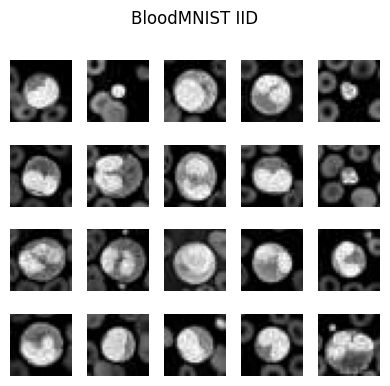

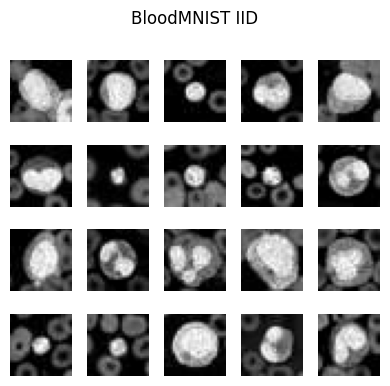

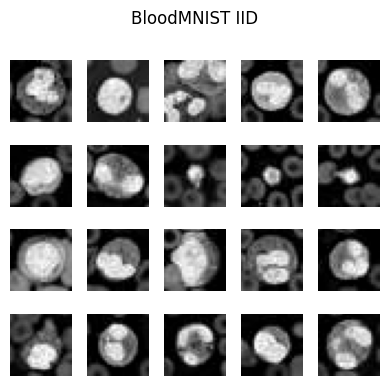

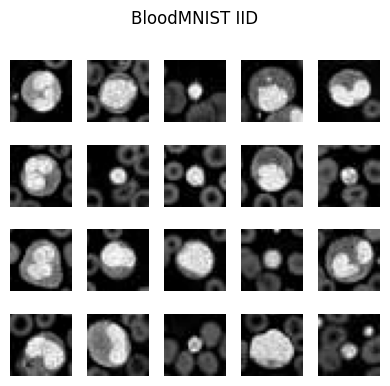

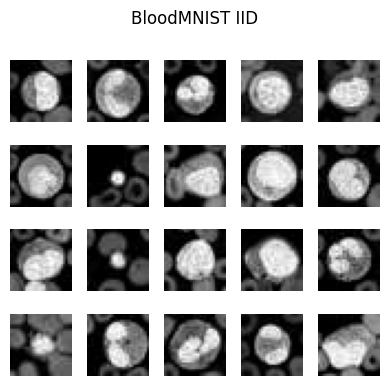

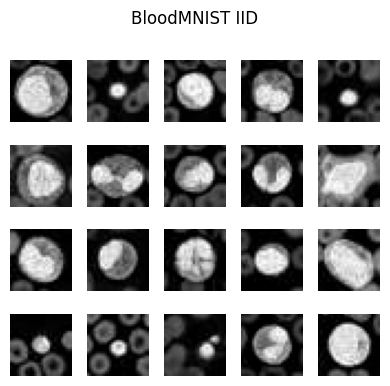

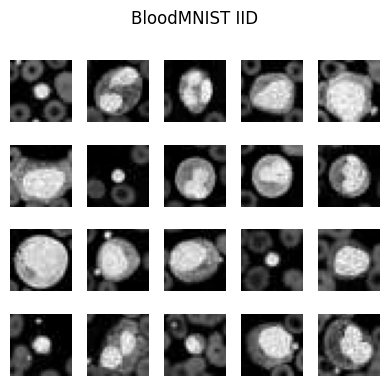

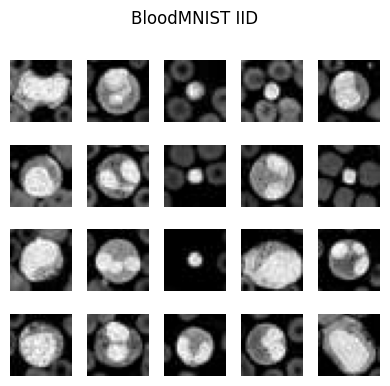

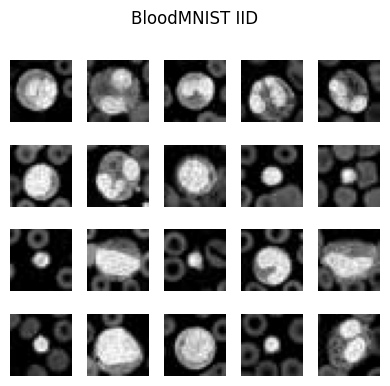

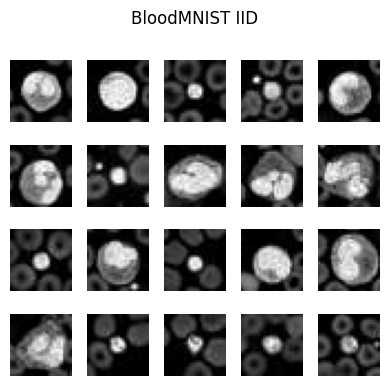

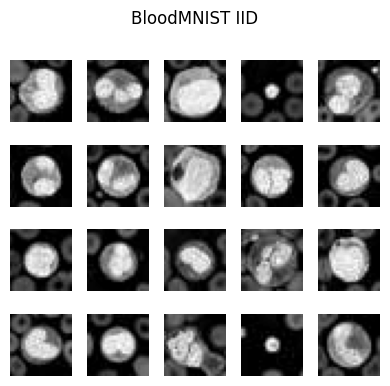

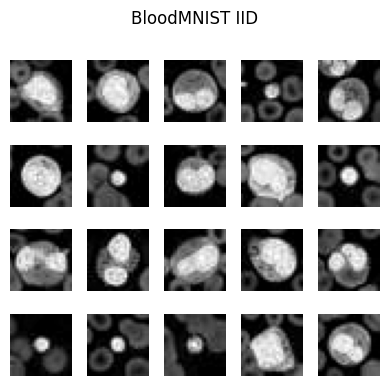

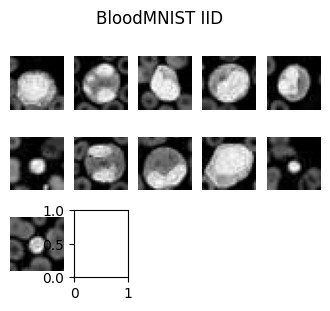

In [299]:
# plot samples

all_labels = []

for loader in bloodmnist_iid_train:
    for images, labels in loader:
        all_labels.append(labels)
        plot_samples((images, labels), 0, title="BloodMNIST IID", plot_name="bloodmnist_iid_train")

for loader in bloodmnist_iid_test:
    for images, labels in loader:
        all_labels.append(labels)
        plot_samples((images, labels), 0, title="BloodMNIST IID", plot_name="bloodmnist_iid_test")

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [300]:
class CNN_2(nn.Module):

    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc2 = nn.Linear(64 * 7 * 7, 8)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc2(x)

        x = F.softmax(x, dim=1)

        return x

model_0 = CNN_2()

In [301]:
output = model_0(images)

print(output.shape)
print(output)

torch.Size([11, 8])
tensor([[0.1558, 0.1103, 0.0666, 0.1008, 0.0661, 0.2668, 0.0995, 0.1342],
        [0.0763, 0.1017, 0.0959, 0.1048, 0.0325, 0.3052, 0.1403, 0.1432],
        [0.0477, 0.0774, 0.0724, 0.0889, 0.0574, 0.3417, 0.2134, 0.1010],
        [0.1433, 0.1817, 0.0825, 0.0712, 0.0277, 0.2486, 0.1457, 0.0993],
        [0.1315, 0.0784, 0.0904, 0.1381, 0.0447, 0.2426, 0.1748, 0.0994],
        [0.1508, 0.0579, 0.2200, 0.1057, 0.0756, 0.1277, 0.1320, 0.1303],
        [0.0638, 0.0878, 0.0850, 0.1804, 0.0480, 0.1968, 0.2320, 0.1062],
        [0.1740, 0.1456, 0.0772, 0.1005, 0.0373, 0.1496, 0.0911, 0.2247],
        [0.1293, 0.2183, 0.1029, 0.0715, 0.0362, 0.1862, 0.1280, 0.1276],
        [0.1723, 0.0471, 0.2357, 0.0594, 0.1104, 0.1655, 0.0965, 0.1131],
        [0.1369, 0.0732, 0.1738, 0.1233, 0.0757, 0.1984, 0.0897, 0.1291]],
       grad_fn=<SoftmaxBackward0>)


### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [302]:
B_FedAvg_1 = FedProx(model_0, bloodmnist_iid_train, 1, bloodmnist_iid_test)

Clients' weights: [0.49919743178170145, 0.23595505617977527, 0.26484751203852325]
====> i: 0 Loss: 2.076012566231227 Server Test Accuracy: 19.828900610768518
====> i: 1 Loss: 1.8402990240537909 Server Test Accuracy: 18.713676869430454


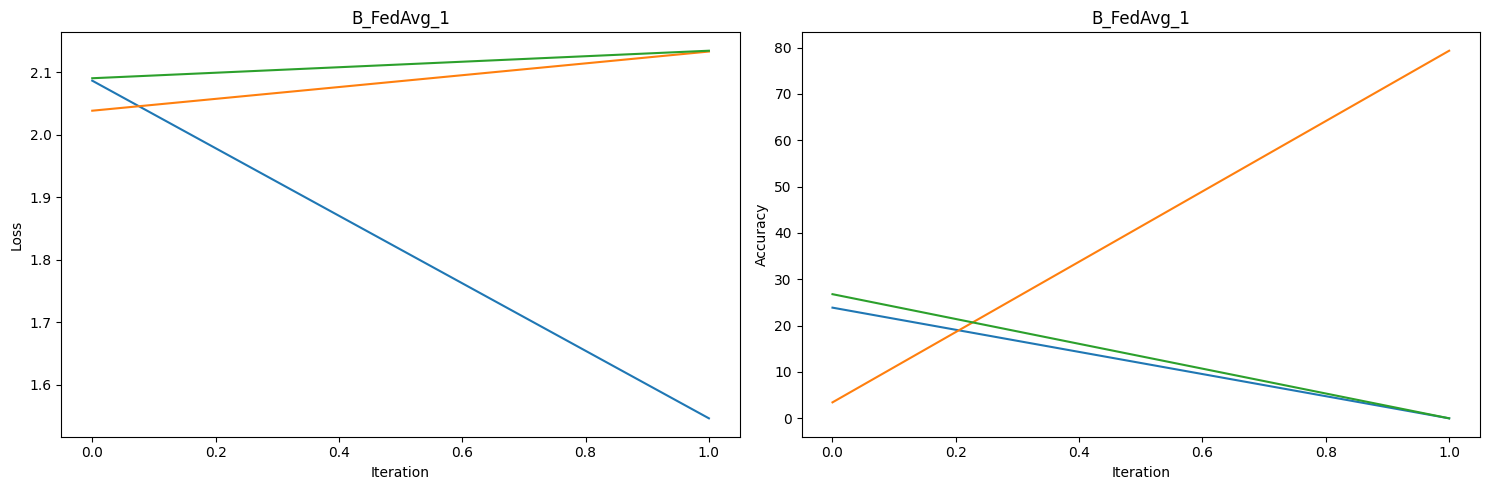

In [303]:
plot_acc_loss("B_FedAvg_1", B_FedAvg_1[1], B_FedAvg_1[2])

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [304]:
B_FedAvg_2 = FedProx(model_0, bloodmnist_iid_train, 10, bloodmnist_iid_test, epochs=2, lr=0.1, mu=0.3)

Clients' weights: [0.49919743178170145, 0.23595505617977527, 0.26484751203852325]
====> i: 0 Loss: 2.0765356795554366 Server Test Accuracy: 20.810442397364085
====> i: 1 Loss: 1.9294977853998516 Server Test Accuracy: 18.045064403134365
====> i: 2 Loss: 2.0050897328467086 Server Test Accuracy: 17.5317963295353
====> i: 3 Loss: 1.8722017647558 Server Test Accuracy: 33.482680199017565
====> i: 4 Loss: 1.8385267914011238 Server Test Accuracy: 29.556225831048444
====> i: 5 Loss: 1.8562285548037165 Server Test Accuracy: 21.119187310724367
====> i: 6 Loss: 1.9283938270127985 Server Test Accuracy: 25.99177953230943
====> i: 7 Loss: 1.7992355945979037 Server Test Accuracy: 43.88015401213889
====> i: 8 Loss: 1.9084929702369973 Server Test Accuracy: 21.43725932837296
====> i: 9 Loss: 1.8754647346407798 Server Test Accuracy: 17.882336778182797
====> i: 10 Loss: 1.860653289057087 Server Test Accuracy: 20.745548316188156


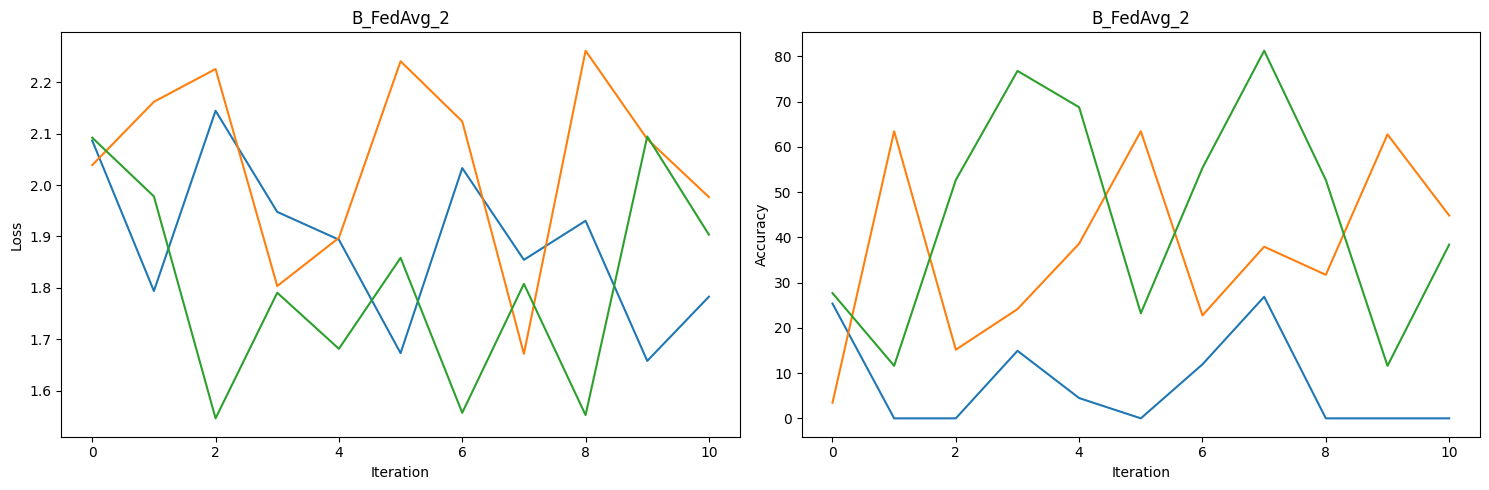

In [305]:
plot_acc_loss("B_FedAvg_2", B_FedAvg_2[1], B_FedAvg_2[2])

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [306]:
B_FedAvg_3 = FedProx(model_0, bloodmnist_non_iid_train, 1, bloodmnist_non_iid_test)

Clients' weights: [0.30364963503649633, 0.33284671532846716, 0.3635036496350365]
====> i: 0 Loss: 2.0779858449949833 Server Test Accuracy: 9.195546831871434
====> i: 1 Loss: 1.83515169707528 Server Test Accuracy: 30.328569383957962


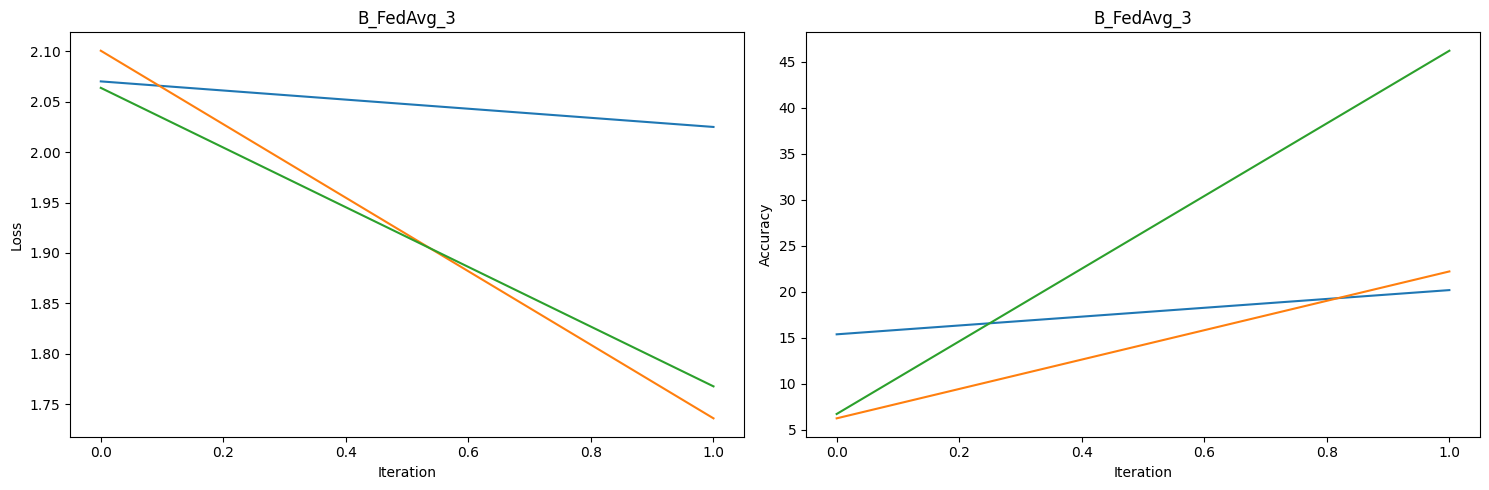

In [307]:
plot_acc_loss("B_FedAvg_3", B_FedAvg_3[1], B_FedAvg_3[2])

In [308]:
B_FedAvg_4 = FedProx(model_0, bloodmnist_non_iid_train, 10, bloodmnist_non_iid_test, epochs=2, lr=0.1, mu=0.3)

Clients' weights: [0.30364963503649633, 0.33284671532846716, 0.3635036496350365]
====> i: 0 Loss: 2.07931402651933 Server Test Accuracy: 9.42669038418287
====> i: 1 Loss: 1.8881113289046465 Server Test Accuracy: 20.969351244147298
====> i: 2 Loss: 1.800254361820917 Server Test Accuracy: 53.4593837535014
====> i: 3 Loss: 1.8729676211837436 Server Test Accuracy: 27.160440818663233
====> i: 4 Loss: 1.8316345267052196 Server Test Accuracy: 46.710216933488724
====> i: 5 Loss: 2.0428823384055255 Server Test Accuracy: 12.82954057535423
====> i: 6 Loss: 1.7193622676125409 Server Test Accuracy: 48.72743257887096
====> i: 7 Loss: 1.74689268491564 Server Test Accuracy: 29.17990553885788
====> i: 8 Loss: 1.7747282891377913 Server Test Accuracy: 51.56423153202887
====> i: 9 Loss: 1.7529669914802497 Server Test Accuracy: 31.248032059539145
====> i: 10 Loss: 1.830198245326968 Server Test Accuracy: 30.48160870187491


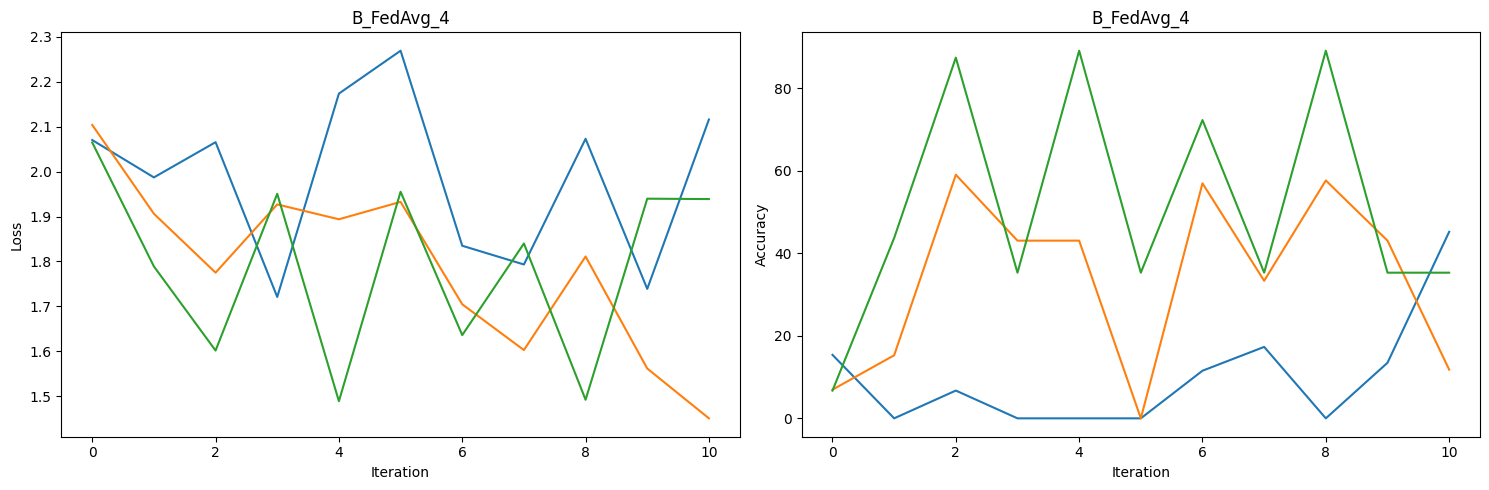

In [309]:
plot_acc_loss("B_FedAvg_4", B_FedAvg_4[1], B_FedAvg_4[2])

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf

The results aren't that satisfying. To improve the results, we could increase the number of clients.